In [511]:
import numpy as np
import pandas as pd
import networkx as nx
import time
import timeit
import datetime
import http.client
import requests
import json

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from heapq import *
import planarity
from sklearn.linear_model import LinearRegression

# S&P500 Data Processing&Statistics

In [88]:
changes_df = pd.read_excel('S&P500 changes.xlsx',index_col='date')
changes_df.index = pd.to_datetime(changes_df.index)
changes_df = changes_df.loc['2017-04-01':]
changes_df.tail()

<ipython-input-88-0e917c9ae7a8>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  changes_df = changes_df.loc['2017-04-01':]


,Added Ticker,Added Security,Removed Ticker,Removed Security,Reason
date,,,,,
2017-06-19,ANSS,Ansys,R,Ryder System,Market capitalization changes.[74]
2017-06-19,RE,Everest Re,MJN,Mead Johnson,Reckitt Benckiser acquired Mead Johnson Nutrit...
2017-06-02,INFO,IHS Markit,TGNA,Tegna,TGNA spins off Cars.com[76]
2017-04-05,IT,Gartner,DNB,Dun & Bradstreet,IT acquiring CEB[77]
2017-04-04,DXC,DXC Technology,SWN,Southwestern Energy,"HPE spins off Everett, merged with CSC to form..."


In [89]:
cur_components_df = pd.read_excel('S&P500 current components.xlsx')
cur_components_df.head()

,Symbol,Security,SEC filings,GICS聽Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,A,Agilent Technologies,reports,Health Care,Health Care Equipment,"Santa Clara, California",36682,1090872,1999
1,AAL,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",42086,6201,1934
2,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",42194,1158449,1932
3,AAPL,Apple Inc.,reports,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",30285,320193,1977
4,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",41274,1551152,2013 (1888)


In [94]:
# generate SP500 components from now to historical periods.
# initialize
components_mark_df = pd.DataFrame()
prev_date = 0
stocks = list(cur_components_df['Symbol'])
# generate historical components based on changes
for date in changes_df.index[:-1]:
    if date != prev_date:
        components_mark_df.loc[date, stocks] = 1
        prev_date = date
        removed = changes_df.loc[date, 'Removed Ticker']
        added = changes_df.loc[date, 'Added Ticker']
        
        if type(removed) == str:
            stocks.append(removed)            
        elif isinstance(removed, pd.Series):
            for ele in list(removed.values):
                if type(ele) == str: stocks.append(ele)
                    
        if type(added) == str:
            stocks.remove(added)
        elif isinstance(added, pd.Series):
            for ele in list(added.values):
                if type(ele) == str: stocks.remove(ele)
                    
components_mark_df = components_mark_df.sort_index()
components_mark_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,RIG,BBBY,MUR,MNK,RAI,YHOO,TDC,R,MJN,TGNA
2017-04-05,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-06-02,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2017-06-19,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2017-07-26,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-08,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# save results
components_mark_df.index.name = 'date'
components_mark_df.to_csv('components_mark_df.csv')

In [494]:
def api_getprice(tick, startdate, enddate):
    # Use Yahoo Finance API to retrive all the prices of 600+ stocks
    conn = http.client.HTTPSConnection("yahoofinance-stocks1.p.rapidapi.com")
    headers = {
        'X-RapidAPI-Key': "c3d37faa96msh4a93641804d5669p116e33jsnfd6f8414a59b",
        'X-RapidAPI-Host': "yahoofinance-stocks1.p.rapidapi.com"
    }
    conn.request("GET", "/stock-prices?EndDateInclusive={}&StartDateInclusive={}&Symbol={}&OrderBy=Ascending".format(enddate,startdate,tick), headers=headers)
    res = conn.getresponse()
    time.sleep(0.5)
    try:
        data = json.loads(res.read().decode("utf-8"))
    except:
        print("data for {} does not exist".format(tick))  
    return data

In [105]:
'''
startdate = '2016-04-01'
enddate = '2022-06-28'

#components_price_df = pd.DataFrame(columns=components_mark_df.columns)

for tick in components_price_df.columns:
    # retrive information for stock tick
    if components_price_df[tick].isnull().values.all():
        data = api_getprice(tick, startdate, enddate)
        for item in data['results']:
            try:
                date_index = pd.to_datetime(item['date'])
                close = item['close']
                components_price_df.loc[date_index, tick] = close
            except:
                continue

components_price_df.index = pd.to_datetime(components_price_df.index)
components_price_df = components_price_df.sort_index()
components_price_df.to_csv('components_price_new.csv')
'''

In [104]:
components_price_df = pd.read_csv('components_price_new.csv',index_col='date')

In [117]:
components_price_df = pd.read_csv('components_price_new.csv',index_col='date')
components_price_df.index = pd.to_datetime(components_price_df.index)
#components_price_df = components_price_df
for tick in components_price_df.columns:
    # delete stock whose information can not be retrived
    if components_price_df[tick].isnull().values.all():
        components_price_df = components_price_df.drop(columns=[tick])
        #print(tick)
        continue
    # process abnormal data
    for d in components_price_df.index:
        if type(components_price_df.loc[d,tick]) == str:
            components_price_df.loc[d,tick]=np.nan
        else:
            if components_price_df.loc[d,tick]<0 or components_price_df.loc[d,tick]>9999:
                components_price_df.loc[d,tick]=np.nan
# fillna with previous price
components_price_df = components_price_df.fillna(method="ffill")
components_price_df = components_price_df.fillna(method="bfill")

In [119]:
components_mark_df = components_mark_df[components_price_df.columns]

In [120]:
components_ret_df = ((components_price_df/components_price_df.shift())-1).iloc[1:]
print(f"There are {components_ret_df.shape[0]} rows and {components_ret_df.shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {components_ret_df.index[0]} to {components_ret_df.index[-1]}")
components_ret_df.head()

There are 1571 rows and 566 columns in the dataset.
Data timeperiod covers: 2016-04-04 00:00:00 to 2022-06-28 00:00:00


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,PDCO,CHK,SNI,AN,RIG,BBBY,MUR,TDC,R,TGNA
date,,,,,,,,,,,,,,,,,,,,,
2016-04-04,-0.007442,-0.003796,-0.007418,0.010274,0.031174,0.007514,-0.009112,0.003081,-0.007306,-0.006936,...,0.001726,0.0,-0.002225,-0.010689,-0.003497,-0.004847,-0.018137,-0.012086,-0.009034,-0.018851
2016-04-05,-0.018745,-0.011176,0.007788,-0.011789,-0.011316,-0.016866,-0.005852,-0.006616,-0.011861,-0.003492,...,-0.028645,0.0,-0.008623,0.007277,0.010526,-0.004262,-0.013854,-0.007103,-0.017762,-0.005809
2016-04-06,0.024962,-0.000771,-0.003677,0.010473,0.023061,0.021589,0.021863,0.024025,0.004731,0.013062,...,0.016630,0.0,0.007199,0.007662,0.004630,-0.005096,0.049383,0.017886,-0.011522,0.031910
2016-04-07,-0.019135,-0.013882,-0.025332,-0.021810,-0.009851,-0.010053,-0.016252,-0.010221,-0.022412,-0.016981,...,-0.020720,0.0,-0.030226,-0.019770,-0.031106,0.003278,-0.008519,-0.016790,-0.020884,-0.021341
2016-04-08,0.001773,0.003650,0.001797,0.001106,-0.013997,-0.015578,0.006378,-0.005633,0.006512,0.003092,...,0.000891,0.0,0.000768,-0.010417,0.030916,-0.040433,0.051146,-0.009531,0.024306,0.009346


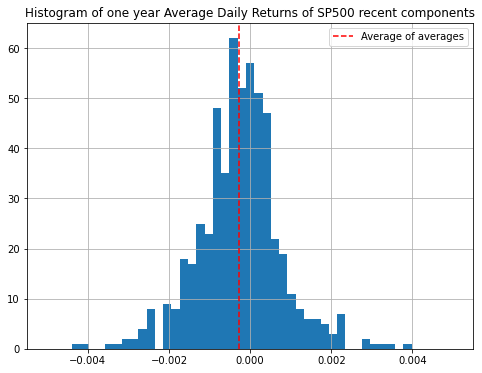

In [123]:
# one year return of SP500 recent components
active_components = components_mark_df[components_mark_df.iloc[[-1],:]==1].columns

plt.figure(figsize=(8,6))
plt.title('Histogram of one year Average Daily Returns of SP500 recent components')
components_ret_df[active_components].loc['2021-06-01':'2022-06-28'].mean().hist(bins=np.linspace(-.005,.005, 50))
plt.axvline(components_ret_df[active_components].loc['2021-06-01':'2022-06-28'].mean().mean(), color='red', linestyle='--', label = 'Average of averages')
plt.legend()
plt.show();

In [184]:
correlation_matrix = components_ret_df[active_components].loc['2021-06-01':'2022-06-28'].corr()
correlation_matrix = correlation_matrix.fillna(value=0.0001)
correlation_matrix.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,PDCO,CHK,SNI,AN,RIG,BBBY,MUR,TDC,R,TGNA
A,1.000000,0.321970,0.343723,0.590099,0.206113,0.303739,0.598548,0.612774,0.631346,0.680844,...,0.295054,0.134905,0.0001,0.215848,0.066236,0.219321,0.110618,0.307659,0.344350,0.143346
AAL,0.321970,1.000000,0.354378,0.492916,0.039215,0.300702,0.443424,0.226443,0.416960,0.350634,...,0.283800,0.210032,0.0001,0.319516,0.243040,0.324434,0.321063,0.402536,0.430593,0.280313
AAP,0.343723,0.354378,1.000000,0.409693,0.269604,0.342982,0.308804,0.284990,0.468702,0.320679,...,0.286270,0.199091,0.0001,0.511389,0.118431,0.212947,0.257044,0.273571,0.410796,0.219772
AAPL,0.590099,0.492916,0.409693,1.000000,0.184751,0.374868,0.564246,0.469883,0.670667,0.662270,...,0.340060,0.202983,0.0001,0.252588,0.208557,0.272564,0.245131,0.383238,0.414400,0.157167
ABBV,0.206113,0.039215,0.269604,0.184751,1.000000,0.455902,0.099448,0.344642,0.291643,0.131132,...,0.282016,0.189248,0.0001,0.118242,0.087050,-0.002865,0.144596,0.091903,0.041544,0.112238


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


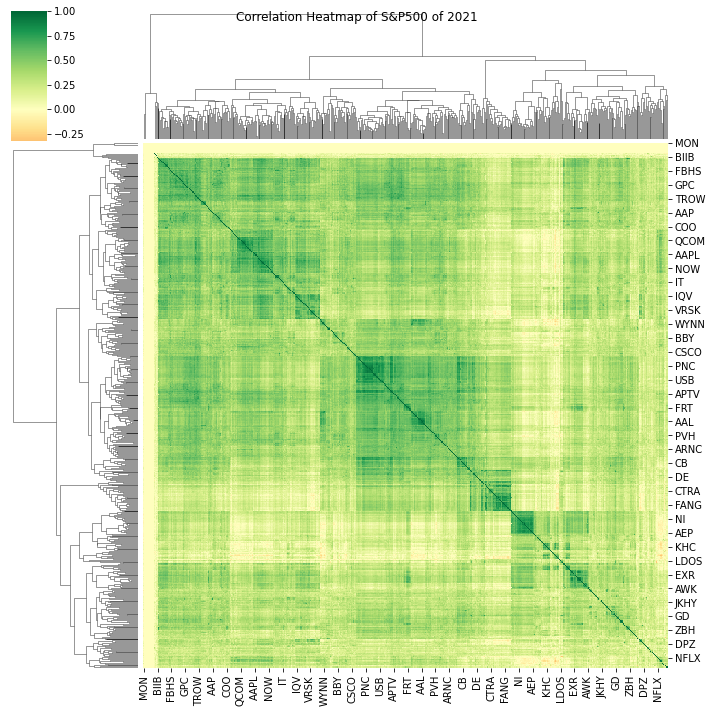

In [185]:
sns.clustermap(correlation_matrix, cmap="RdYlGn", center =0.).fig.suptitle('Correlation Heatmap of S&P500 of 2021');

# Graph Filter Algorithm

In [198]:
def PMFG(G):
    # sort edges weight in descending order
    h = []
    for u,v,d in G.edges(data=True):
        heappush(h,(d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()
    
    # PMFG algorithm
    res = nx.Graph()
    for (w,u,v) in heapsort:
        res.add_edge(u,v,weight=w)
        if not planarity.is_planar(res):
            res.remove_edge(u,v)
            
        if res.number_of_edges() == 3*(G.number_of_nodes()-2):
            break   

    return res

In [127]:
def MST(G):
    # sort edges weight in descending order
    h = []
    for u,v,d in G.edges(data=True):
        heappush(h, (d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()
    
    # kruskal MST algorithm
    def find_subtree(parent, i):
        # i represents index of nodes
        if parent[i] == i:
            return i
        return find_subtree(parent, parent[i])
            
    res = nx.Graph()
    parent = [j for j in range(len(G.nodes))]
    subtree_sizes = [0]*len(G.nodes)
    i = 0
    e = 0 # number of edges in MST
    
    while e<(len(G.nodes)-1):
        w, u, v = heapsort[i]
        i += 1
        u_index = list(G.nodes).index(u)
        v_index = list(G.nodes).index(v)
        x = find_subtree(parent, u_index)
        y = find_subtree(parent, v_index)
        # if u and v belongs to different subtree
        if x!=y:
            e += 1
            res.add_edge(u, v, weight = w)
            # connect two trees
            parent[y] = x
    return res 

In [446]:
def FULL(G):
    # sort edges weight in descending order
    h = []
    threshold = 0.3
    
    for u,v,d in G.edges(data=True):
        if d['weight'] > threshold:
            heappush(h,(d['weight'],u,v))
    heapsort = [heappop(h) for i in range(len(h))]
    heapsort.reverse()    
    
    res = nx.Graph()
    for (w,u,v) in heapsort:
        res.add_edge(u,v,weight=w) 
    
    # find unconnected nodes, connect these nodes to cluster using maximum weight
    unconnected = [x for x in list(G.nodes) if x not in list(res.nodes)]
    for node in unconnected:
        h_ = []
        for u, v, d in G.edges(node, data=True):
            heappush(h_,(d['weight'],u,v))
        heapsort_ = [heappop(h_) for i in range(len(h_))]
        heapsort_.reverse()
        for (w,u,v) in heapsort_:
            if v in list(res.nodes):
                res.add_edge(u,v,weight=w)
                print(u)
                break
        
    return res

In [381]:
# graph from corr
G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))

In [331]:
G0_PMFG = PMFG(G0)

KeyboardInterrupt: 

In [188]:
G0_MST = MST(G0)

In [447]:
G0_FULL = FULL(G0)

CERN


In [367]:
G0_FULL.edges(data=True)

EdgeDataView([('FOX', 'FOXA', {'weight': 0.9876521903269146}), ('GOOG', 'GOOGL', {'weight': 0.984823320616139}), ('NWS', 'NWSA', {'weight': 0.9752172045851528}), ('CCL', 'NCLH', {'weight': 0.955288244631624}), ('CCL', 'RCL', {'weight': 0.9382164371389851}), ('DAL', 'UAL', {'weight': 0.9473331829666244}), ('UAL', 'AAL', {'weight': 0.9343133854491974}), ('AVB', 'EQR', {'weight': 0.9444419374897727}), ('DHI', 'LEN', {'weight': 0.9388653261966302}), ('FITB', 'KEY', {'weight': 0.9358585199971872}), ('FITB', 'CFG', {'weight': 0.9355758154437666}), ('COF', 'DFS', {'weight': 0.9344167208095981}), ('MLM', 'VMC', {'weight': 0.9329928788572022})])

In [372]:
print('Nodes number of original graph: ',len(list(G0.nodes)))
print('Nodes number of PMFG graph: ',len(list(G0_PMFG.nodes)))
print('Nodes number of MST graph: ',len(list(G0_MST.nodes)))
print('Nodes number of FULL graph: ',len(list(G0_FULL.nodes)))
print('Edges number of original graph: ',len(list(G0.edges)))
print('Edges number of PMFG graph: ',len(list(G0_PMFG.edges)))
print('Edges number of MST graph: ',len(list(G0_MST.edges)))
print('Edges number of FULL graph: ',len(list(G0_FULL.edges)))

Nodes number of original graph:  501
Nodes number of PMFG graph:  501
Nodes number of MST graph:  566
Nodes number of FULL graph:  474
Edges number of original graph:  125250
Edges number of PMFG graph:  1497
Edges number of MST graph:  565
Edges number of FULL graph:  16824


# Generate Monthly Rank By Centrality 2019-2022

In [133]:
dateindex_new = []
year_prev, month_prev = 0, 0
# Extract the first available day at every month from 2019 
for date in components_price_df.index:
    if date.year >= 2017:
        if ((date.year != year_prev) or (date.month != month_prev)):
            dateindex_new.append(date)
            year_prev = date.year
            month_prev = date.month
dateindex_new = pd.to_datetime(dateindex_new)[5:]
dateindex_new

DatetimeIndex(['2017-06-01', '2017-07-03', '2017-08-01', '2017-09-01',
               '2017-10-02', '2017-11-01', '2017-12-01', '2018-01-02',
               '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01',
               '2018-06-01', '2018-07-02', '2018-08-01', '2018-09-04',
               '2018-10-01', '2018-11-01', '2018-12-03', '2019-01-02',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-03', '2019-07-01', '2019-08-01', '2019-09-03',
               '2019-10-01', '2019-11-01', '2019-12-02', '2020-01-02',
               '2020-02-03', '2020-03-02', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-03', '2020-09-01',
               '2020-10-01', '2020-11-02', '2020-12-01', '2021-01-04',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-03',
               '2021-06-01', '2021-07-01', '2021-08-02', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-03',
      

### MST

In [134]:
# rank dataframe
centrality_MST_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)
rank_MST_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)

In [143]:
for date in dateindex_new:
    # find lastest SP500 components
    temp = components_mark_df.loc[:date]
    temp = temp.iloc[-1,:]
    temp = temp[temp==1]
    latest_components = list(temp.index)
    # corr_matrix of latest_components (look back 1 year)
    correlation_matrix = components_ret_df[latest_components].loc[(date-datetime.timedelta(days=365)):date].corr()
    correlation_matrix = correlation_matrix.fillna(value=0.0001)
    # graph filter
    G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
    G0_MST = MST(G0)
    # centrality sorting(ascending) and ranking
    centrality = nx.closeness_centrality(G0_MST)
    centrality_sorted ={k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
    centrality_rank = dict(zip(list(centrality_sorted.keys()),[i for i in range(len(centrality_sorted))]))
    # record values
    centrality_MST_df.loc[date, centrality.keys()] = list(centrality.values())
    rank_MST_df.loc[date, centrality_rank.keys()] = list(centrality_rank.values())

In [144]:
centrality_MST_df.to_csv('centrality_MST_df.csv')
rank_MST_df.to_csv('rank_MST_df.csv')

### PMFG

In [246]:
# rank dataframe
centrality_PMFG_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)
rank_PMFG_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)

In [247]:
for date in dateindex_new[19:]:
    # find lastest SP500 components
    temp = components_mark_df.loc[:date]
    temp = temp.iloc[-1,:]
    temp = temp[temp==1]
    latest_components = list(temp.index)
    # corr_matrix of latest_components (look back 1 year)
    correlation_matrix = components_ret_df[latest_components].loc[(date-datetime.timedelta(days=365)):date].corr()
    correlation_matrix = correlation_matrix.fillna(value=0.0001)
    # graph filter
    G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
    G0_PMFG = PMFG(G0)
    # centrality sorting(ascending) and ranking
    centrality = nx.closeness_centrality(G0_PMFG)
    centrality_sorted ={k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
    centrality_rank = dict(zip(list(centrality_sorted.keys()),[i for i in range(len(centrality_sorted))]))
    # record values
    centrality_PMFG_df.loc[date, centrality.keys()] = list(centrality.values())
    rank_PMFG_df.loc[date, centrality_rank.keys()] = list(centrality_rank.values())

In [248]:
centrality_PMFG_df.to_csv('centrality_PMFG_df.csv')
rank_PMFG_df.to_csv('rank_PMFG_df.csv')

### Full Network

In [448]:
# rank dataframe
centrality_FULL_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)
rank_FULL_df = pd.DataFrame(index = dateindex_new, columns = components_price_df.columns)

In [449]:
for date in dateindex_new:
    # find lastest SP500 components
    temp = components_mark_df.loc[:date]
    temp = temp.iloc[-1,:]
    temp = temp[temp==1]
    latest_components = list(temp.index)
    # corr_matrix of latest_components (look back 1 year)
    correlation_matrix = components_ret_df[latest_components].loc[(date-datetime.timedelta(days=365)):date].corr()
    correlation_matrix = correlation_matrix.fillna(value=0.0001)
    # graph filter
    G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
    G0_FULL = FULL(G0)
    # centrality sorting(ascending) and ranking
    centrality = nx.closeness_centrality(G0_FULL)
    centrality_sorted ={k: v for k, v in sorted(centrality.items(), key=lambda item: item[1])}
    centrality_rank = dict(zip(list(centrality_sorted.keys()),[i for i in range(len(centrality_sorted))]))
    # record values
    centrality_FULL_df.loc[date, centrality.keys()] = list(centrality.values())
    rank_FULL_df.loc[date, centrality_rank.keys()] = list(centrality_rank.values())

DOW
FOX
FOXA
ARNC
COL
XL
MON
CHK
DOW
FOX
FOXA
ARNC
COL
XL
MON
CHK
CMG
DOW
FOX
FOXA
ARNC
COL
XL
MON
CHK
FOX
FOXA
ULTA
HRB
ARNC
BHF
COL
XL
MON
CHK
CMG
EFX
FOX
FOXA
ULTA
HRB
ARNC
BHF
COL
XL
MON
CHK
ADM
EFX
FOX
FOXA
NRG
ULTA
ARNC
BHF
COL
XL
MON
CHK
ADM
EFX
FOX
FOXA
LUMN
NRG
ARNC
COL
SRCL
XL
MON
CHK
ADM
DRI
EFX
FOX
FOXA
NEM
NRG
STZ
TAP
HRB
COTY
ARNC
COL
SRCL
XL
MON
CHK
DRI
EFX
FOX
FOXA
NEM
NRG
STZ
TAP
HRB
COTY
ARNC
COL
XL
MON
SIG
CHK
EFX
FOX
FOXA
NRG
COTY
ARNC
COL
XL
MON
CHK
FOX
FOXA
HRB
COTY
ARNC
COL
XL
MON
FOX
FOXA
ARNC
COL
XL
MON
FOX
FOXA
ULTA
ARNC
COL
XL
MON
FOX
FOXA
ARNC
SCG
COL
XL
FOX
FOXA
ARNC
SCG
COL
XL
FOX
FOXA
ARNC
COL
EVHC
XL
FOX
FOXA
ARNC
SCG
COL
EVHC
FOX
FOXA
ARNC
LLL
COL
FOX
FOXA
ARNC
LLL
FOX
FOXA
ARNC
LLL
FOX
FOXA
ARNC
LLL
FOX
FOXA
ARNC
LLL
ARNC
LLL
DOW
ARNC
LLL
CTVA
DOW
LW
ARNC
LLL
AMCR
CTVA
LW
ARNC
AMCR
CTVA
LW
ARNC
AMCR
NEM
ARNC
AMCR
NEM
ARNC
AMCR
NEM
ARNC
NEM
ARNC
ARNC
LW
ARNC
ARNC
NLOK
VNT
VNT
VNT
VNT
VNT
FE
OGN
OGN
OGN
OGN
NLOK
OGN
NLOK
OGN
NLOK
OGN
NLOK
OGN
CEG
CEG
NLO

In [450]:
centrality_FULL_df.to_csv('centrality_FULL_df.csv')
rank_FULL_df.to_csv('rank_FULL_df.csv')

In [350]:
centrality_sorted

{'HCA': 0.002320185614849188,
 'UHS': 0.002320185614849188,
 'T': 0.002320185614849188,
 'VZ': 0.002320185614849188,
 'CHTR': 0.002320185614849188,
 'CMCSA': 0.002320185614849188,
 'FDX': 0.002320185614849188,
 'UPS': 0.002320185614849188,
 'CTVA': 0.002320185614849188,
 'FMC': 0.002320185614849188,
 'PARA': 0.004176334106728538,
 'CSX': 0.004640371229698376,
 'NSC': 0.004640371229698376,
 'UNP': 0.004640371229698376,
 'FOX': 0.005220417633410673,
 'FOXA': 0.005220417633410673,
 'WBD': 0.0069605568445475635,
 'WBA': 0.009056208367637153,
 'HUM': 0.01039786886654636,
 'HSIC': 0.01039786886654636,
 'CNC': 0.01122969837587007,
 'MOH': 0.01122969837587007,
 'ABC': 0.012206193886815294,
 'CAH': 0.012206193886815294,
 'ANTM': 0.013368688542702465,
 'CVS': 0.013368688542702465,
 'CI': 0.014775918915618512,
 'MCK': 0.016514262317455983,
 'UNH': 0.016514262317455983,
 'DGX': 0.14521738036486762,
 'KMB': 0.14861326837181457,
 'HRL': 0.14890837017557115,
 'KHC': 0.14896753122848158,
 'CAG': 0.149

# Back Test

In [156]:
components_ret_df

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,PDCO,CHK,SNI,AN,RIG,BBBY,MUR,TDC,R,TGNA
date,,,,,,,,,,,,,,,,,,,,,
2016-04-04,-0.007442,-0.003796,-0.007418,0.010274,0.031174,0.007514,-0.009112,0.003081,-0.007306,-0.006936,...,0.001726,0.000000,-0.002225,-0.010689,-0.003497,-0.004847,-0.018137,-0.012086,-0.009034,-0.018851
2016-04-05,-0.018745,-0.011176,0.007788,-0.011789,-0.011316,-0.016866,-0.005852,-0.006616,-0.011861,-0.003492,...,-0.028645,0.000000,-0.008623,0.007277,0.010526,-0.004262,-0.013854,-0.007103,-0.017762,-0.005809
2016-04-06,0.024962,-0.000771,-0.003677,0.010473,0.023061,0.021589,0.021863,0.024025,0.004731,0.013062,...,0.016630,0.000000,0.007199,0.007662,0.004630,-0.005096,0.049383,0.017886,-0.011522,0.031910
2016-04-07,-0.019135,-0.013882,-0.025332,-0.021810,-0.009851,-0.010053,-0.016252,-0.010221,-0.022412,-0.016981,...,-0.020720,0.000000,-0.030226,-0.019770,-0.031106,0.003278,-0.008519,-0.016790,-0.020884,-0.021341
2016-04-08,0.001773,0.003650,0.001797,0.001106,-0.013997,-0.015578,0.006378,-0.005633,0.006512,0.003092,...,0.000891,0.000000,0.000768,-0.010417,0.030916,-0.040433,0.051146,-0.009531,0.024306,0.009346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,-0.000702,0.004601,0.017062,-0.003827,0.028508,0.012285,0.017350,0.009865,0.012981,0.006446,...,0.008897,-0.009096,0.000000,0.008611,-0.064690,-0.019403,-0.066121,-0.006790,-0.003618,-0.003817
2022-06-23,0.042179,-0.009160,0.022730,0.021574,0.012808,-0.002896,0.052137,0.007303,-0.001990,0.030958,...,-0.002822,-0.077908,0.000000,-0.006670,-0.054755,0.085236,-0.017857,0.033908,-0.017458,0.012931
2022-06-24,0.022681,0.070878,0.025024,0.024517,0.019338,0.026694,0.026949,0.030506,0.047371,0.029418,...,0.007075,0.097721,0.000000,0.041450,0.064024,-0.018233,0.019139,0.051309,0.011230,0.013239


In [482]:
def backtest(num):
    # num: number of shares to hold
    ret_df = pd.DataFrame(index = components_ret_df.index, columns = ['equal_weight','MST_top','MST_bottom','PMFG_top','PMFG_bottom']).loc['2019-06-01':]

    for date in ret_df.index:
        # find the first date of this month, the rank data is available on this date.
        prev_date = 0
        for temp_date in dateindex_new:
            if temp_date <= date:
                prev_date = temp_date
            else:
                break

        # MST
        temp = rank_MST_df.loc[prev_date]
        max_rank = temp.max()
        total = list(temp[temp>=0].index)
        ret_df.loc[date,'equal_weight'] = components_ret_df.loc[date, total].mean()
        top = list(temp[temp < num].index)
        bottom = list(temp[temp > (max_rank-num)].index)
        ret_df.loc[date,'MST_top'] = components_ret_df.loc[date, top].mean()
        ret_df.loc[date,'MST_bottom'] = components_ret_df.loc[date, bottom].mean()
        # PMFG
        temp = rank_PMFG_df.loc[prev_date]
        max_rank = temp.max()
        top = list(temp[temp < num].index)
        bottom = list(temp[temp > (max_rank-num)].index)
        ret_df.loc[date,'PMFG_top'] = components_ret_df.loc[date, top].mean()
        ret_df.loc[date,'PMFG_bottom'] = components_ret_df.loc[date, bottom].mean()
        # FULL NETWORK
        '''
        temp = rank_FULL_df.loc[prev_date]
        max_rank = temp.max()
        top = list(temp[temp < num].index)
        bottom = list(temp[temp > (max_rank-num)].index)
        ret_df.loc[date,'FULL_top'] = components_ret_df.loc[date, top].mean()
        ret_df.loc[date,'FULL_bottom'] = components_ret_df.loc[date, bottom].mean()    
        '''
    return ret_df

In [483]:
ret_df_3 = backtest(3)

<AxesSubplot:xlabel='date'>

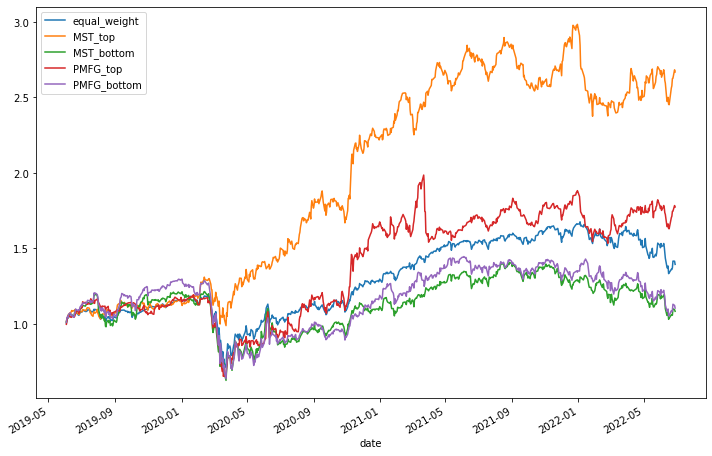

In [484]:
(ret_df_3 + 1).cumprod().plot(figsize=(12,8))

In [486]:
ret_df_5 = backtest(5)

<AxesSubplot:xlabel='date'>

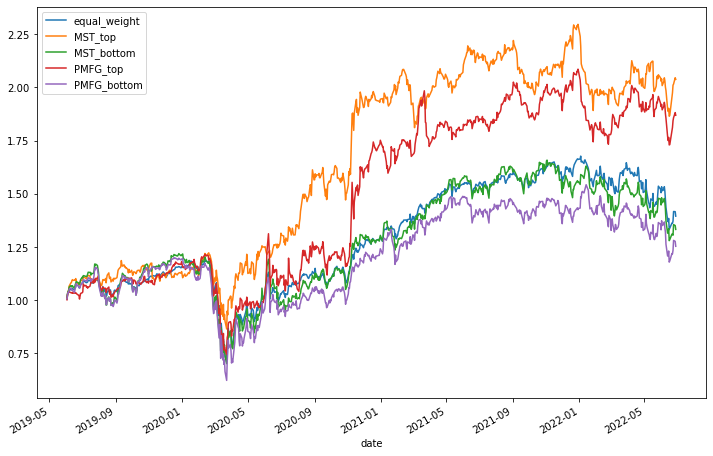

In [487]:
(ret_df_5 + 1).cumprod().plot(figsize=(12,8))

In [488]:
ret_df_10 = backtest(10)

<AxesSubplot:xlabel='date'>

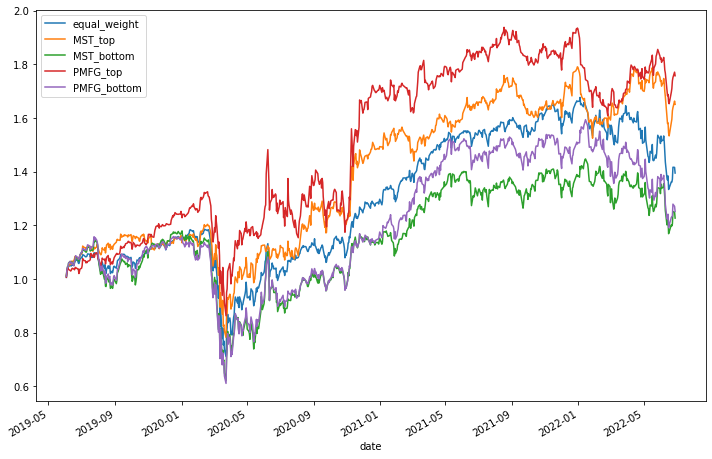

In [489]:
(ret_df_10 + 1).cumprod().plot(figsize=(12,8))

# Return and Risk Analysis

In [490]:
# statistics for backtesting between 2019.06.01-2022.06.28

In [535]:
stat_df = pd.DataFrame(index=['Cumulative Return', 'beta', 'sharp', 'IC', 'IR'], \
columns=['all stocks', 'MST 3 stocks','MST 5 stocks','MST 10 stocks','PMFG 3 stocks','PMFG 5 stocks','PMFG 10 stocks'])

In [536]:
startdate = '2016-04-01'
enddate = '2022-06-28'
# get price of S&P500 ETF
#SP500_data = api_getprice('IVV', startdate, enddate)

In [537]:
SP500price_df = pd.DataFrame()

tick = 'IVV'
for item in SP500_data['results']:
    try:
        date_index = pd.to_datetime(item['date'])
        close = item['close']
        SP500price_df.loc[date_index, tick] = close
    except:
        continue

SP500price_df = SP500price_df.sort_index()

In [538]:
SP500price_df = SP500price_df.fillna(method="ffill")

In [539]:
SP500ret_df = ((SP500price_df/SP500price_df.shift())-1).loc[ret_df_3.index,:]

In [540]:
# 1. cumulative return
stat_df.loc['Cumulative Return','all stocks'] = '{:.2%}'.format((ret_df_3 + 1)['equal_weight'].cumprod()[-1])

stat_df.loc['Cumulative Return','MST 3 stocks'] = '{:.2%}'.format((ret_df_3 + 1)['MST_top'].cumprod()[-1])
stat_df.loc['Cumulative Return','MST 5 stocks'] = '{:.2%}'.format((ret_df_5 + 1)['MST_top'].cumprod()[-1])
stat_df.loc['Cumulative Return','MST 10 stocks'] = '{:.2%}'.format((ret_df_10 + 1)['MST_top'].cumprod()[-1])

stat_df.loc['Cumulative Return','PMFG 3 stocks'] = '{:.2%}'.format((ret_df_3 + 1)['PMFG_top'].cumprod()[-1])
stat_df.loc['Cumulative Return','PMFG 5 stocks'] = '{:.2%}'.format((ret_df_5 + 1)['PMFG_top'].cumprod()[-1])
stat_df.loc['Cumulative Return','PMFG 10 stocks'] = '{:.2%}'.format((ret_df_10 + 1)['PMFG_top'].cumprod()[-1])

In [541]:
# 2. beta
# beta = cov/var
market_var = np.var(list(SP500ret_df['IVV'].values))

stat_df.loc['beta','all stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_3['equal_weight'].values))[0,1]/market_var

stat_df.loc['beta','MST 3 stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_3['MST_top'].values))[0,1]/market_var
stat_df.loc['beta','MST 5 stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_5['MST_top'].values))[0,1]/market_var
stat_df.loc['beta','MST 10 stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_10['MST_top'].values))[0,1]/market_var

stat_df.loc['beta','PMFG 3 stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_3['PMFG_top'].values))[0,1]/market_var
stat_df.loc['beta','PMFG 5 stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_5['PMFG_top'].values))[0,1]/market_var
stat_df.loc['beta','PMFG 10 stocks'] = np.cov(list(SP500ret_df['IVV'].values), list(ret_df_10['PMFG_top'].values))[0,1]/market_var

In [542]:
stat_df

,all stocks,MST 3 stocks,MST 5 stocks,MST 10 stocks,PMFG 3 stocks,PMFG 5 stocks,PMFG 10 stocks
Cumulative Return,139.48%,266.87%,203.71%,165.08%,177.47%,186.87%,175.74%
beta,1.034973,0.705277,0.793047,0.807458,0.915615,0.90974,0.841243
sharp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IR,NaN,NaN,NaN,NaN,NaN,NaN,NaN


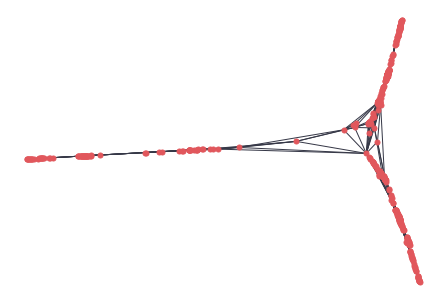

In [125]:
nx.draw(G0_PMFG, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G0_PMFG))

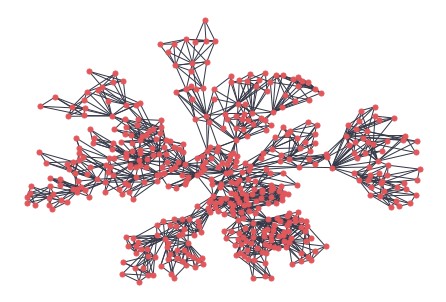

In [126]:
nx.draw(G0_PMFG, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_PMFG))

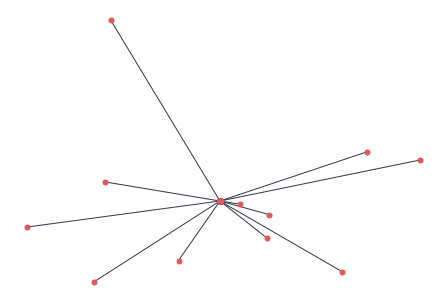

In [543]:
nx.draw(G0_MST, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G0_MST))

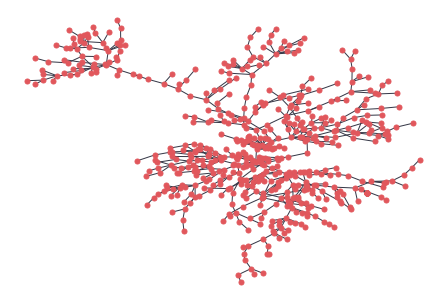

In [544]:
nx.draw(G0_MST, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_MST))